In this project I will be exploring a data set with reviews from women for clothes from E-Commerce webistes. Since it is real commercial data the company names have been made anonymous. There are 10 feature variables and 23486 rows. The 10 feature variables will provide some essential insights to this data. 

Here is a brief explanation of the columns 

Clothing ID : An integer identifier for the specific garment being reviewed

Age : A positive integer indicating the reviewer’s age

Title : A short textual field providing the headline or summary of the review

Review Text : A string containing the main body or content of the reviewer’s feedback

Rating : An ordinal integer score from 1 (lowest) to 5 (highest), reflecting the customer’s overall product satisfaction

Reccommended ID : A binary indicator for whether the reviewer recommends the product (1 = recommend, 0 = not recommend)

Positive Feedback Count : A positive integer showing how many other users marked this review as helpful or positive

Division Name : A categorical field indicating the high-level product division

Department Name : A categorical attribute specifying the product’s department

Class Name : A categorical label for the product’s type

In this project I will be answering the question "How accurately can we predict whether a reviewer will recommend a clothing item using their review text, rating, and other features?" 

This will be done by first doing some Exploratory Data Analysis. This is essential because by identifying ull or missing values, outliers, or other issues with data quality early we can perform data cleansing and feature engineering in order to byuld a more accurate classifier. 

In [334]:
!pip install vaderSentiment


In [335]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report








In [382]:
df = pd.read_csv(r"C:\Users\shery\Downloads\Womens Clothing E-Commerce Reviews.csv")
df.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [383]:
df.shape

(23486, 11)

<H3> Data Cleaning <H3>

Firtst we want to check if there are duplicated values and missing values in our data frame and then figure out how to deal with them.

In [384]:
duplicate_rows_df = df[df.duplicated()]
duplicate_rows_df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name


In [385]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

We can see that the columns Title, Review Text, Divivision Name, Department Name, and Class Name have missing values. The Title and Review Text columns have the largest amount of missing values and so dropping them may not be the best option as it can skew and make our results less meaningful.

In [386]:
proportion_missing_title = df["Title"].isnull().sum() / len(df)
proportion_missing_Review_Text = df["Review Text"].isnull().sum() / len(df)
proportion_missing_title, proportion_missing_Review_Text

(0.1622243038405859, 0.035978881035510515)

Looking at the proportions of the 2 columns with the most missing data we can see that the missing proportion of Title is around 16% and the missing proportion for Review Text is around 4%. Considering the factors that we will be using Review Text and Title in our analsyis we can move forward with inputting the missing values with an empty string so that it does not interfere with the analysis. 

In [387]:
df["Review Text"].fillna("", inplace=True) 
df["Title"].fillna("", inplace=True) 

For Division Name, Departmnent Name, and Class Name. Since the missing proportion is much less than 5% we can consider dropping those missing values. 

In [388]:
df.dropna(subset=["Division Name", "Department Name", "Class Name"], inplace=True)
df.isnull().sum()


Unnamed: 0                 0
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

<H2> Data Transformation <H2>

We want to check if we need to stadardize the numeric columns we can do this by looking at the mean, max, Q3 (75%), median, and min. Also plotting histograms can help see this as well.

In [389]:
df[["Age", "Rating", "Positive Feedback Count"]].describe()


,Age,Rating,Positive Feedback Count
count,23472.000000,23472.000000,23472.000000
mean,43.200707,4.195552,2.537151
std,12.280913,1.110188,5.703597
min,18.000000,1.000000,0.000000
25%,34.000000,4.000000,0.000000
50%,41.000000,5.000000,1.000000
75%,52.000000,5.000000,3.000000
max,99.000000,5.000000,122.000000


The Positive Feedback Count column sticks out to me. Specifically, the Q3 showing that 75% of reviews received 3 or fewer positive feedbacks while the max is 122 which is far beyond Q3. This indicates some extreme outliers. 

array([[<AxesSubplot:title={'center':'Positive Feedback Count'}>]],
      dtype=object)

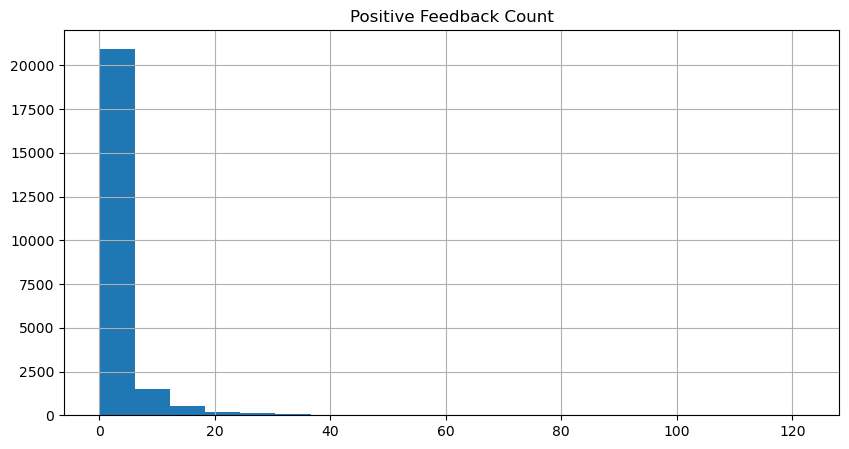

In [390]:
df[["Positive Feedback Count"]].hist(bins=20, figsize=(10, 5))


This histogram shows "Positive Feedback Count" is skewed. The Positive Feedback Count histogram shows that most of the valies are lower but there are a few very high outliers as can be seen in the max value. Since there are outliers we can not just standardize the Positive Feedback Count. Instead, we must first do a log transformation (takes care of the outliers) and then standardize (scales the values properly and makes the mean = 0 and the std dev = 1). 

In [391]:
df["Positive Feedback Log"] = np.log1p(df["Positive Feedback Count"])

scalar = StandardScaler()

df["Positive Feedback Count Standardized"] = scalar.fit_transform(df[["Positive Feedback Log"]])

df.head(4)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Positive Feedback Log,Positive Feedback Count Standardized
0,0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0.000000,-0.837658
1,1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,1.609438,0.974138
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.000000,-0.837658
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.000000,-0.837658


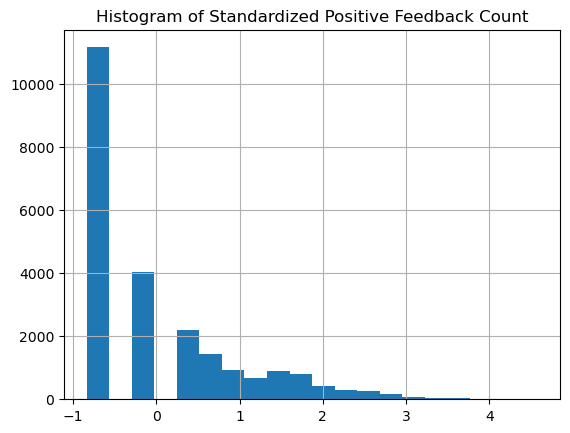

In [392]:
df["Positive Feedback Count Standardized"].hist(bins= 20)
plt.title("Histogram of Standardized Positive Feedback Count")
plt.show()

<H3>Feature Engineering 

- Scaling 
- Log Transformation 
- Binning 
- One-Hot Encoding 
- Feature Integration

First we will do binning for the age category. Since there is such a wide variety of ages placing them in bins will make our analysis easier. The bins that they belong to will be added as another column in our data frame.

In [393]:
df["Age Group"] = pd.cut(df["Age"], bins=[18, 30, 40, 50, 60, 100], labels=["18-30", "31-40", "41-50", "51-60", "60+"])


In [394]:
df.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Positive Feedback Log,Positive Feedback Count Standardized,Age Group
0,0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0.000000,-0.837658,31-40
1,1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,1.609438,0.974138,31-40
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.000000,-0.837658,51-60


We are using one-hot encoding to convert categorical variables into numerical features that logistic regression can interpret without assuming any inherent order between categories. This prevents the model from misinterpreting categories like "Dresses" or "Tops" as ordinal values and allows us to measure the impact of each category individually. We will apply one-hot encoding to the columns Division Name, Department Name, and Class Name, as they represent non-ordinal categorical variables.

In [395]:
df["Division Name"].unique()

array(['Initmates', 'General', 'General Petite'], dtype=object)

In [396]:
df["Department Name"].unique()

array(['Intimate', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend'],
      dtype=object)

In [397]:
df["Class Name"].unique()

array(['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
       'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
       'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering',
       'Casual bottoms', 'Chemises'], dtype=object)

In [398]:
df_encoded = pd.get_dummies(df, columns=["Division Name", "Department Name","Class Name","Age Group"], drop_first=True)


The on-hot encoding is done for our categorical variables. I checked to see the unique values of each column first because if it a very large number of unqie values then one-hot encoding will be diffcult and make the df too large. However, the unqique values range from 4-20 which is fine for encoding and logistic regression. To explain the code the function pd.get_dummies converts the columsn specified into binary columns and the  drop first agrgyment drops the first category, placing it as a refernece/base level to ensure no multicollinearity. 

In [399]:
df["Sentiment Score"] = df["Review Text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df_encoded["Sentiment Score"] = df["Sentiment Score"]



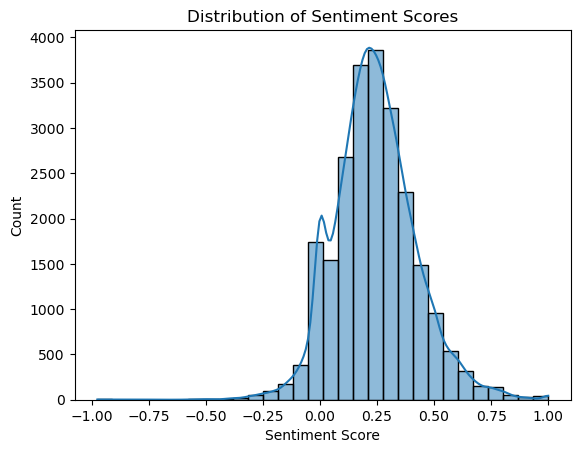

In [420]:
sns.histplot(df["Sentiment Score"], bins=30, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.show()

Using the library textblob's polarity scoring function we are able to get sentiment scores for the Review Text column. This is an indicator of wheher the review was poistive or negative based on the average of sentiments throught the text. Textblob utilizes NLTK to compute a polairty socre of -1 to 1.  

Data Exploration 

- Bivariate Analysis (Crosstab Table)
The crosstab table gives us an insight into each type of clothing and wether it is mostly reccomended or not. It shows the proportion of reccomended or not for each department name.

- Multivariate Analysis (Correlation Matrix and Box Plot)
The correlation matrix helps to show the correlation between each feature. This is necessary before training the logistic regression model because it reveals multicollinearity. Multicollinearity happens when two or more features in a dataset are highly correlated, meaning they provide very similar information to the model. In logistic regression, this can make it hard for the model to figure out which feature is actually important, leading to unstable coefficients and less reliable predictions.



In [421]:
pd.crosstab(df["Department Name"], df["Recommended IND"], normalize='index')


Recommended IND,0,1
Department Name,,
Bottoms,0.148723,0.851277
Dresses,0.191803,0.808197
Intimate,0.149856,0.850144
Jackets,0.163760,0.836240
Tops,0.184849,0.815151
Trend,0.260504,0.739496


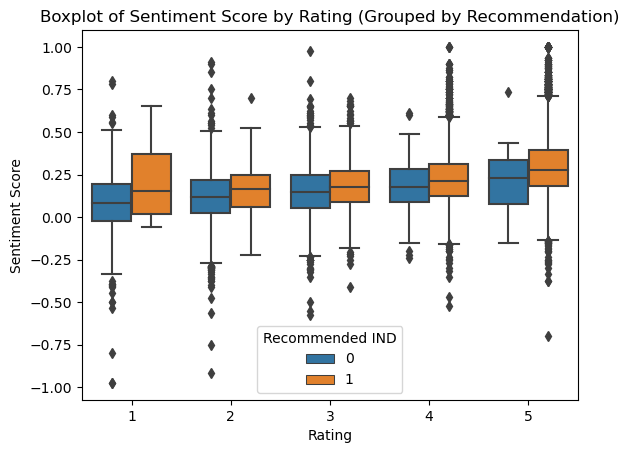

In [422]:
sns.boxplot(x="Rating", y="Sentiment Score", hue="Recommended IND", data=df)
plt.title("Boxplot of Sentiment Score by Rating (Grouped by Recommendation)")
plt.show()

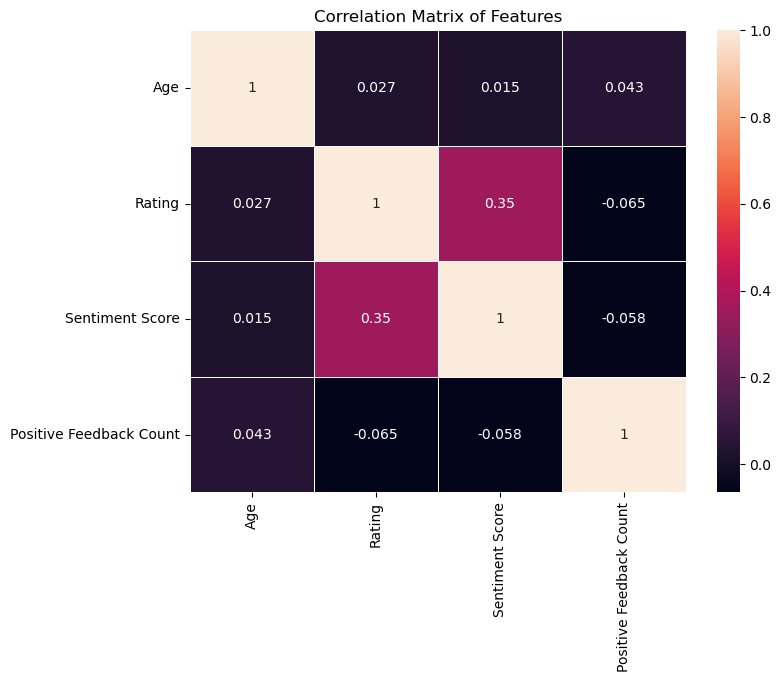

In [423]:
corr_matrix = df[["Age", "Rating", "Sentiment Score", "Positive Feedback Count"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

<H2> Fitting the Model

<H3> Splitting The Data Into Training And Test Data 

First we select the X features and the Y features. For the X features which are our predictor variables we are using all the variables from the ecoded df (including the categorical ones we hot-ecoded). In order to do this we can just drop the Recommended ID variable in order to use the rest of the features as the X features. Since the variable we are trying to predict is the Recommended IND that is the Y feature. 

Next we have to split the data into training and test data. This is done using the train_test_split function from the sklearn.model_selection module and setting the test_size to 0.2 which gives us a 80/20 split. That means 80% of the data is training data and 20% of the data is test data. 

In [432]:
df_encoded2 = df_encoded.drop(columns=["Title", "Review Text","Positive Feedback Count","Positive Feedback Log","Clothing ID","Age"])


In [433]:
X = df_encoded2.drop(columns=["Recommended IND"])
y = df_encoded2["Recommended IND"]

In [434]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [435]:
#Fitting the Model 

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [436]:
y_pred = model.predict(X_test)


<H2> Evaluating the Model's Performance

In [441]:
sample_input = pd.DataFrame([{
    "Unnamed: 0": 0,  # Row index or placeholder (does not affect prediction)
    "Rating": 4,
    "Positive Feedback Count Standardized": 0.5,  # Example standardized value
    "Division Name_General Petite": 0,
    "Division Name_Initmates": 1,  # Sample division category
    "Department Name_Dresses": 1,
    "Department Name_Intimate": 0,
    "Department Name_Jackets": 0,
    "Department Name_Tops": 0,
    "Department Name_Trend": 0,
    "Class Name_Casual bottoms": 0,
    "Class Name_Chemises": 0,
    "Class Name_Dresses": 1,  # Selected category
    "Class Name_Fine gauge": 0,
    "Class Name_Intimates": 0,
    "Class Name_Jackets": 0,
    "Class Name_Jeans": 0,
    "Class Name_Knits": 0,
    "Class Name_Layering": 0,
    "Class Name_Legwear": 0,
    "Class Name_Lounge": 0,
    "Class Name_Outerwear": 0,
    "Class Name_Pants": 0,
    "Class Name_Shorts": 0,
    "Class Name_Skirts": 0,
    "Class Name_Sleep": 0,
    "Class Name_Sweaters": 0,
    "Class Name_Swim": 0,
    "Class Name_Trend": 0,
    "Age Group_31-40": 1,  # Age group matches the age (35)
    "Age Group_41-50": 0,
    "Age Group_51-60": 0,
    "Age Group_60+": 0,
    "Sentiment Score": 0.7  # Example sentiment score
}])

In [442]:
predicted_class = model.predict(sample_input)[0]  
predicted_prob = model.predict_proba(sample_input)[0][1]  

In [443]:
predicted_class


1

In [444]:
predicted_prob

0.9298552976277049

This is an example of a sample input. The model we built predicts the Reccomended IND and the probability that a customer will reccomend this clothing item. For this mannual made sample input it predicts that teh Reccomended IND will be 1 and there is a 98.98.55% probability that a 35 year old customer will reccomend this item.

0.97


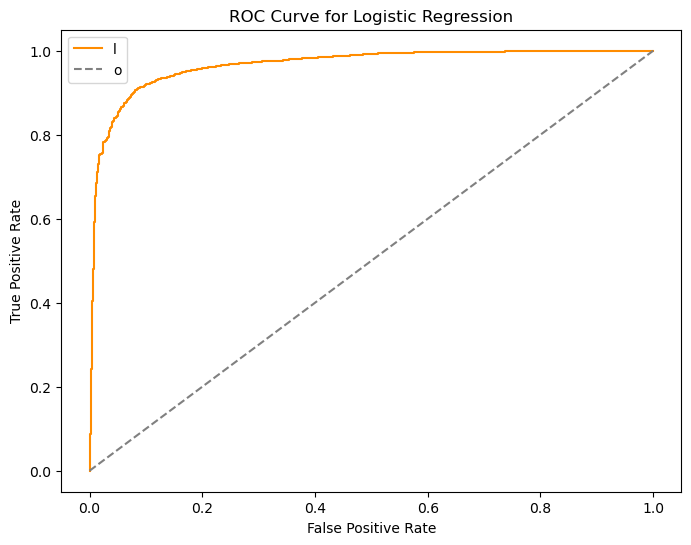

In [445]:

y_pred_probs = model.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

auc_score = roc_auc_score(y_test, y_pred_probs)

print("{:.2f}".format(auc_score))


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle="--", color='gray') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend("loc")
plt.show()

The ROC curve (Receiver Operating Characteristic curve) shows how well a model distinguishes between positive (1) and negative (0) classes by plotting the true positive rate against the false positive rate at different thresholds. The AUC (Area Under the Curve) measures the overall performance—an AUC of 1.0 means perfect classification, while 0.5 means random guessing. A higher AUC (closer to 1) indicates that the model is better at predicting the correct class.

In [446]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.73      0.79       863
           1       0.94      0.97      0.96      3832

    accuracy                           0.93      4695
   macro avg       0.89      0.85      0.87      4695
weighted avg       0.92      0.93      0.92      4695



The F1-score is a balance between how many of the predicted recommendations were actually correct and how many of the actual recommendations the model was able to catch. In the report, the F1-score for class 1 (recommendations) is 0.95, meaning the model is doing a great job at balancing false positives and false negatives for that class. However, the F1-score for class 0 (no recommendation) is lower at 0.79, meaning the model struggles more with identifying when a review is genuinely negative. The overall accuracy of 92% shows that the model is performing well on the test set.


In [448]:
y_train_pred_probs = model.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_probs)

# AUC for test data
y_test_pred_probs = model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_probs)

print(f"Training AUC: {train_auc:.2f}")
print(f"Test AUC: {test_auc:.2f}")


Training AUC: 0.96
Test AUC: 0.97
